# The Deep Learning Homework 3 - Question No. 10 Part B
Bahar Mahdavi - SN: 40152521337

## B. Train the network of part A with torch.optim.lr_scheduler (gamma=0.9), batchsize=50

### Setting up the Environment

In [11]:
import torch
x=torch.tensor([1]).to('cuda')
print(torch.cuda.is_available())
# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")

True


### Load MNIST Dataset from TorchVision

In [12]:
from torchvision import datasets, transforms

# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
                                ])

# Download and load the training data
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transforms.ToTensor())
trainLoader = torch.utils.data.DataLoader(train_set, batch_size=50, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transforms.ToTensor())
testLoader = torch.utils.data.DataLoader(test_set, batch_size=50, shuffle=True)

In [13]:
training_data = enumerate(trainLoader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([50, 1, 28, 28])
torch.Size([50])


### Building the Network

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MnistModel(nn.Module):

    def __init__(self):
        super(MnistModel, self).__init__()
        self.convolutaional_neural_network_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2)
        )
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=1568, out_features=1024),
                nn.ReLU(),
                nn.Dropout(p=0.2),
                nn.Linear(in_features=1024, out_features=10),
                nn.Softmax(dim = 1)
        )

    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        x = x.view(-1, 1568)
        x = self.linear_layers(x)
        return x

In [15]:
model = MnistModel()
model.to(device)

MnistModel(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1568, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=1024, out_features=10, bias=True)
    (4): Softmax(dim=1)
  )
)

### Specify Loss Function and Optimizer and Scheduler

In [16]:
from torch import optim
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.9)

summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
            Linear-7                 [-1, 1024]       1,606,656
              ReLU-8                 [-1, 1024]               0
           Dropout-9                 [-1, 1024]               0
           Linear-10                   [-1, 10]          10,250
          Softmax-11                   [-1, 10]               0
Total params: 1,621,706
Trainable params: 1,621,706
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

### Training and Testing the Model with 50 batch_size

In [17]:
epochs = 15
train_loss, val_loss = [], []
accuracy_total_train, accuracy_total_val = [], []

for epoch in range(epochs):

    total_train_loss = 0
    total_val_loss = 0

    model.train()

    total = 0
    # training our model
    for idx, (image, label) in enumerate(trainLoader):

        image, label = image.to(device), label.to(device)

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()    # calc gradients
        optimizer.step()   # update gradients
        scheduler.step()   # to decay learning rate

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_train = total / len(train_set)
    accuracy_total_train.append(accuracy_train)

    total_train_loss = total_train_loss / (idx + 1)
    train_loss.append(total_train_loss)

    # validating our model
    model.eval()
    total = 0
    for idx, (image, label) in enumerate(testLoader):
        image, label = image.cuda(), label.cuda()
        pred = model(image)
        loss = criterion(pred, label)
        total_val_loss += loss.item()

        #pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy_val = total / len(test_set)
    accuracy_total_val.append(accuracy_val)

    total_val_loss = total_val_loss / (idx + 1)
    val_loss.append(total_val_loss)

    if epoch % 5 == 0:
      print("Epoch: {}/{}  ".format(epoch, epochs),
            "Training loss: {:.4f}  ".format(total_train_loss),
            "Testing loss: {:.4f}  ".format(total_val_loss),
            "Train accuracy: {:.4f}  ".format(accuracy_train),
            "Test accuracy: {:.4f}  ".format(accuracy_val))

Epoch: 0/15   Training loss: 2.2966   Testing loss: 2.2965   Train accuracy: 0.1586   Test accuracy: 0.1550  
Epoch: 5/15   Training loss: 2.2965   Testing loss: 2.2965   Train accuracy: 0.1600   Test accuracy: 0.1550  
Epoch: 10/15   Training loss: 2.2965   Testing loss: 2.2965   Train accuracy: 0.1589   Test accuracy: 0.1550  


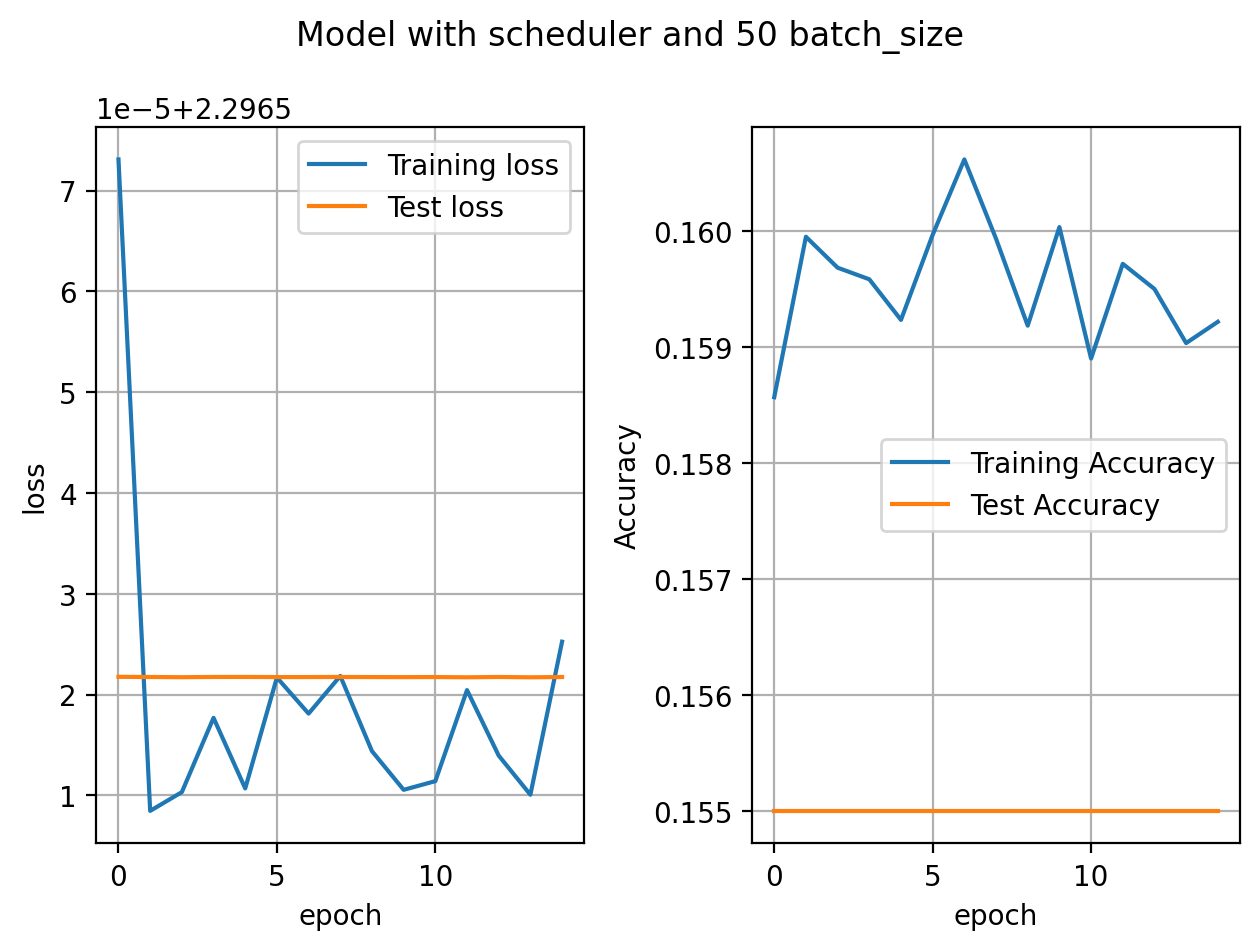

In [18]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.subplot(1,2,1)
plt.plot(train_loss, label='Training loss')
plt.plot(val_loss, label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy_total_train, label='Training Accuracy')
plt.plot(accuracy_total_val, label='Test Accuracy')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.suptitle(f'Model with scheduler and 50 batch_size')
plt.tight_layout()
plt.show()

### Evaluating the Network Model with 50 batch_size

In [19]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[0.10131031 0.10049158 0.10051822 0.10248134 0.09935062 0.09914505
 0.09886009 0.0995727  0.09962843 0.09864165]


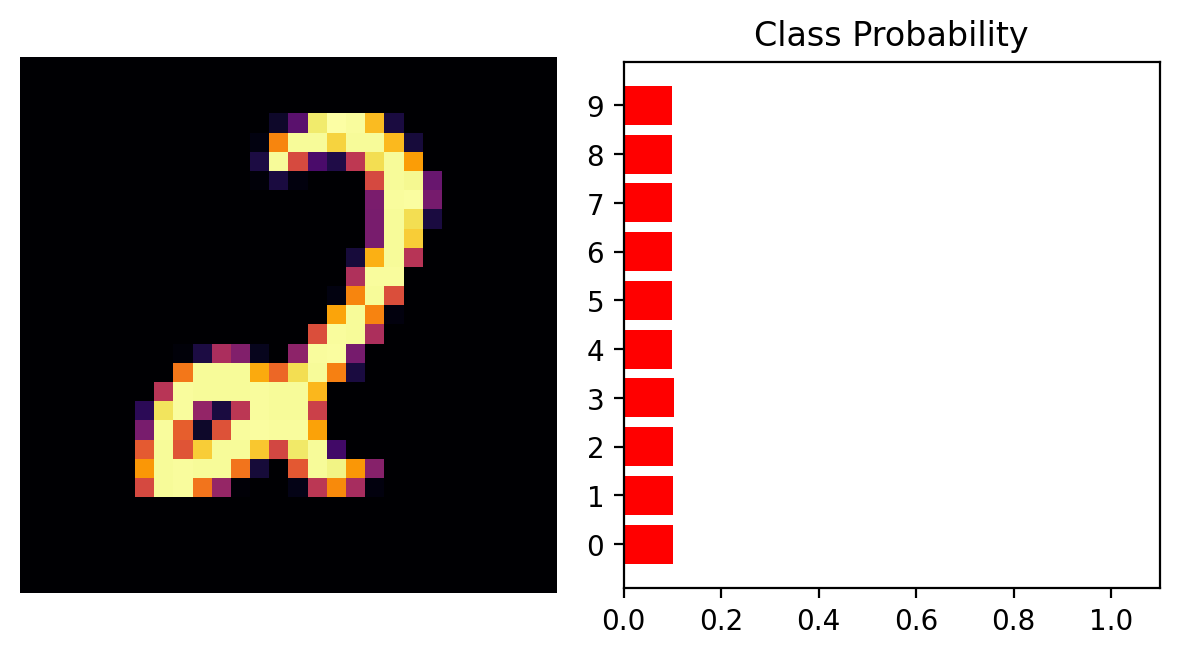

In [20]:
#We take the softmax for probabilites since our outputs are logits
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()